In [63]:
from ngboost import NGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE
from ngboost import NGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
from hyperopt import STATUS_OK, Trials
from data_loader import load_toronto
from preprocessing import pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging
import pickle
import os

NGB_PATH = os.path.join("models", "ngb_model.sav")

### **Load-in Data**
We are using a 72%, 8%, 20% training, validation and testing split:

In [38]:
rent = load_toronto(test_prop=0.2)

# Load in data
X_train = rent['train']['data']
y_train = rent['train']['labels']
X_test = rent['test']['data']
y_test = rent['test']['labels']

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

### **Hyperparameters Set-up**

In [31]:
# Decision Tree hyperparameters
tree_hp = []
for max_f in ['sqrt', 'log2', 0.5, 0.75]: # Subsample columns
    for max_d in [1, 3, 5, 6]: # Subsample rows
        tree_hp.append(DecisionTreeRegressor(
            max_features=max_f, 
            max_depth=max_d, 
            random_state=69))

space = {
    'model': {
        'learning_rate':hp.uniform('learning_rate', .005, 0.5),
        'minibatch_frac':hp.choice('minibatch_frac', [1.0, 0.8, 0.7, 0.6]),
        'Base':hp.choice('Base', tree_hp),
        'n_estimators': hp.choice('n_estimators', [100, 500, 1000, 2000])
    },
    'preprocessing': {
        'n_neighbors': hp.choice('n_neighbors', [3, 5, 10]),
        'mul': hp.choice('mul', [True, False])
    }
}

default_model_params = {"verbose_eval":1,
                        "random_state":69}

### **Run Tuning**

In [40]:
def objective(params):
    params['model'].update(default_params)
    print(params)
    
    # Run through data pipeline
    data_pipeline = pipeline(**params['preprocessing'])
    X_train_c = data_pipeline.fit_transform(X_train)
    X_val_c = data_pipeline.transform(X_val)
    
    # Run through model
    ngb = NGBRegressor(**params['model']).fit(X_train_c, y_train, X_val=X_val_c, Y_val=y_val, early_stopping_rounds=5)
    loss = ngb.evals_result['val']['LOGSCORE'][ngb.best_val_loss_itr]
    results = {'loss':loss, 'status':STATUS_OK}
    return results

In [41]:
TRIALS = Trials()
print('Beginning hyperparameter tuning...')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=TRIALS)
print('Finished tuning!')

Beginning hyperparameter tuning...
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=0.75, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=69, splitter='best'), 'learning_rate': 0.39807986515855387, 'minibatch_frac': 0.7, 'n_estimators': 100, 'verbose_eval': 1, 'random_state': 69}, 'preprocessing': {'mul': True, 'n_neighbors': 3}}
[iter 0] loss=1.5211 val_loss=1.4817 scale=1.0000 norm=1.0651
[iter 1] loss=1.3809 val_loss=1.4231 scale=1.0000 norm=0.9095
[iter 2] loss=1.2811 val_loss=1.1600 scale=1.0000 norm=0.8414
[iter 3] loss=1.0669 val_loss=1.0350 scale=2.0000 norm=1.4140
[iter 4] loss=0.9526 val_loss=0.9542 scale=2.0000 norm=1.4383
[iter 5] loss=0.8026 val_loss=0.9270 scale=2.0000 norm=1.4402
[iter

[iter 0] loss=1.5200 val_loss=1.2472 scale=1.0000 norm=1.0640                    
[iter 1] loss=1.1738 val_loss=1.0115 scale=2.0000 norm=1.4887                    
[iter 2] loss=0.9699 val_loss=0.8684 scale=2.0000 norm=1.2879                    
[iter 3] loss=0.7845 val_loss=0.7624 scale=2.0000 norm=1.2157                    
[iter 4] loss=0.6654 val_loss=0.6780 scale=2.0000 norm=1.1972                    
[iter 5] loss=0.5381 val_loss=0.6322 scale=2.0000 norm=1.1627                    
[iter 6] loss=0.4351 val_loss=0.6360 scale=2.0000 norm=1.1544                    
[iter 7] loss=0.3925 val_loss=0.6354 scale=2.0000 norm=1.1647                    
[iter 8] loss=0.3743 val_loss=0.6413 scale=1.0000 norm=0.6039                    
[iter 9] loss=0.3559 val_loss=0.6318 scale=1.0000 norm=0.6095                    
[iter 10] loss=0.3337 val_loss=0.6521 scale=1.0000 norm=0.6006                   
[iter 11] loss=0.3264 val_loss=0.6712 scale=1.0000 norm=0.5994                   
[iter 12] loss=0

[iter 5] loss=0.3899 val_loss=0.9666 scale=2.0000 norm=1.1625                    
[iter 6] loss=0.3145 val_loss=1.0115 scale=1.0000 norm=0.5932                    
[iter 7] loss=0.3221 val_loss=0.9898 scale=1.0000 norm=0.5934                    
== Early stopping achieved.                                                      
== Best iteration / VAL3 (val_loss=0.7647)                                       
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=69, splitter='best'), 'learning_rate': 0.03327516673636869, 'minibatch_frac': 0.7, 'n_estimators': 100, 'verbose_eval': 1, 'random_state': 69}, 'preprocessing': {'mul': True, 'n_neighbors': 10}}

== Early stopping achieved.                                                      
== Best iteration / VAL82 (val_loss=0.6008)                                      
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=0.75, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=69, splitter='best'), 'learning_rate': 0.046547118706627026, 'minibatch_frac': 0.8, 'n_estimators': 100, 'verbose_eval': 1, 'random_state': 69}, 'preprocessing': {'mul': False, 'n_neighbors': 5}}
[iter 0] loss=1.5200 val_loss=1.3900 scale=1.0000 norm=1.0640                     
[iter 1] loss=1.2622 val_loss=1.3027 scale=2.0000 norm=1.6734                     
[iter 2] loss=1.1701 val_loss=1.2297 scale=2.0000 norm=1.5409                   

[iter 42] loss=0.3355 val_loss=0.6090 scale=1.0000 norm=0.5854                    
[iter 43] loss=0.3297 val_loss=0.6083 scale=1.0000 norm=0.5851                    
[iter 44] loss=0.3240 val_loss=0.6069 scale=1.0000 norm=0.5847                    
[iter 45] loss=0.3185 val_loss=0.6062 scale=1.0000 norm=0.5845                    
[iter 46] loss=0.3131 val_loss=0.6075 scale=1.0000 norm=0.5842                    
[iter 47] loss=0.3087 val_loss=0.6058 scale=1.0000 norm=0.5844                    
[iter 48] loss=0.3040 val_loss=0.6069 scale=1.0000 norm=0.5845                    
[iter 49] loss=0.2999 val_loss=0.6081 scale=2.0000 norm=1.1702                    
[iter 50] loss=0.2930 val_loss=0.6012 scale=1.0000 norm=0.5870                    
[iter 51] loss=0.2883 val_loss=0.6028 scale=1.0000 norm=0.5870                    
[iter 52] loss=0.2843 val_loss=0.6035 scale=1.0000 norm=0.5869                    
[iter 53] loss=0.2800 val_loss=0.6041 scale=1.0000 norm=0.5871                    
[ite

[iter 56] loss=0.2118 val_loss=0.5732 scale=1.0000 norm=0.5511                    
[iter 57] loss=0.2082 val_loss=0.5741 scale=1.0000 norm=0.5509                    
== Early stopping achieved.                                                       
== Best iteration / VAL53 (val_loss=0.5727)                                       
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=69, splitter='best'), 'learning_rate': 0.01173921864663752, 'minibatch_frac': 0.8, 'n_estimators': 100, 'verbose_eval': 1, 'random_state': 69}, 'preprocessing': {'mul': True, 'n_neighbors': 3}}
[iter 0] loss=1.5200 val_loss=1.5817 scale=1.0000 norm=1.0640                    

[iter 87] loss=0.9441 val_loss=1.0414 scale=2.0000 norm=1.4517                    
[iter 88] loss=0.9377 val_loss=1.0393 scale=2.0000 norm=1.4465                    
[iter 89] loss=0.9400 val_loss=1.0376 scale=1.0000 norm=0.7258                    
[iter 90] loss=0.9398 val_loss=1.0356 scale=1.0000 norm=0.7262                    
[iter 91] loss=0.9284 val_loss=1.0327 scale=2.0000 norm=1.4340                    
[iter 92] loss=0.9420 val_loss=1.0289 scale=2.0000 norm=1.4672                    
[iter 93] loss=0.9467 val_loss=1.0274 scale=1.0000 norm=0.7415                    
[iter 94] loss=0.9329 val_loss=1.0259 scale=1.0000 norm=0.7298                    
[iter 95] loss=0.9349 val_loss=1.0236 scale=1.0000 norm=0.7311                    
[iter 96] loss=0.9411 val_loss=1.0222 scale=2.0000 norm=1.4807                    
[iter 97] loss=0.9311 val_loss=1.0197 scale=1.0000 norm=0.7296                    
[iter 98] loss=0.9194 val_loss=1.0174 scale=1.0000 norm=0.7195                    
[ite

[iter 0] loss=1.5211 val_loss=1.1282 scale=1.0000 norm=1.0651                     
[iter 1] loss=1.1424 val_loss=0.8814 scale=2.0000 norm=1.3660                     
[iter 2] loss=0.8372 val_loss=0.7390 scale=2.0000 norm=1.2150                     
[iter 3] loss=0.5763 val_loss=0.7978 scale=2.0000 norm=1.1788                     
[iter 4] loss=0.5598 val_loss=0.7711 scale=1.0000 norm=0.6552                     
[iter 5] loss=0.4659 val_loss=0.7209 scale=2.0000 norm=1.1929                     
[iter 6] loss=0.4046 val_loss=0.7466 scale=1.0000 norm=0.6263                     
[iter 7] loss=0.4173 val_loss=0.7505 scale=1.0000 norm=0.6145                     
[iter 8] loss=0.4024 val_loss=0.8205 scale=1.0000 norm=0.6150                     
[iter 9] loss=0.3733 val_loss=0.9709 scale=1.0000 norm=0.6234                     
== Early stopping achieved.                                                       
== Best iteration / VAL5 (val_loss=0.7209)                                        
{'mo

[iter 3] loss=0.9782 val_loss=0.9835 scale=2.0000 norm=1.3208                     
[iter 4] loss=0.8875 val_loss=0.8834 scale=2.0000 norm=1.2583                     
[iter 5] loss=0.8034 val_loss=0.8056 scale=2.0000 norm=1.2152                     
[iter 6] loss=0.7247 val_loss=0.7417 scale=2.0000 norm=1.1849                     
[iter 7] loss=0.6501 val_loss=0.6859 scale=2.0000 norm=1.1575                     
[iter 8] loss=0.5817 val_loss=0.6407 scale=2.0000 norm=1.1377                     
[iter 9] loss=0.5199 val_loss=0.6020 scale=2.0000 norm=1.1236                     
[iter 10] loss=0.4647 val_loss=0.5720 scale=2.0000 norm=1.1130                    
[iter 11] loss=0.4122 val_loss=0.5450 scale=2.0000 norm=1.0998                    
[iter 12] loss=0.3656 val_loss=0.5325 scale=2.0000 norm=1.0928                    
[iter 13] loss=0.3241 val_loss=0.5252 scale=2.0000 norm=1.0876                    
[iter 14] loss=0.2863 val_loss=0.5183 scale=2.0000 norm=1.0798                    
[ite

[iter 0] loss=1.4840 val_loss=1.4757 scale=1.0000 norm=1.0277                    
[iter 1] loss=1.3296 val_loss=1.3814 scale=1.0000 norm=0.8874                    
[iter 2] loss=1.2416 val_loss=1.3046 scale=2.0000 norm=1.6496                    
[iter 3] loss=1.1618 val_loss=1.2230 scale=2.0000 norm=1.5760                    
[iter 4] loss=1.0852 val_loss=1.1867 scale=2.0000 norm=1.5215                    
[iter 5] loss=1.0210 val_loss=1.1432 scale=1.0000 norm=0.7469                    
[iter 6] loss=0.9712 val_loss=1.0847 scale=2.0000 norm=1.4518                    
[iter 7] loss=0.9177 val_loss=1.0351 scale=2.0000 norm=1.4348                    
[iter 8] loss=0.8571 val_loss=1.0196 scale=2.0000 norm=1.4103                    
[iter 9] loss=0.8211 val_loss=0.9978 scale=2.0000 norm=1.4140                    
[iter 10] loss=0.7870 val_loss=0.9627 scale=1.0000 norm=0.7055                   
[iter 11] loss=0.7633 val_loss=0.9556 scale=1.0000 norm=0.6973                   
[iter 12] loss=0

[iter 50] loss=1.1840 val_loss=1.3124 scale=2.0000 norm=1.6081                   
[iter 51] loss=1.1802 val_loss=1.3104 scale=1.0000 norm=0.8027                   
[iter 52] loss=1.1772 val_loss=1.3090 scale=1.0000 norm=0.8011                   
[iter 53] loss=1.1730 val_loss=1.3071 scale=1.0000 norm=0.7987                   
[iter 54] loss=1.1703 val_loss=1.3051 scale=2.0000 norm=1.5949                   
[iter 55] loss=1.1666 val_loss=1.3033 scale=1.0000 norm=0.7966                   
[iter 56] loss=1.1642 val_loss=1.3011 scale=1.0000 norm=0.7956                   
[iter 57] loss=1.1616 val_loss=1.2953 scale=2.0000 norm=1.5888                   
[iter 58] loss=1.1558 val_loss=1.2915 scale=1.0000 norm=0.7918                   
[iter 59] loss=1.1527 val_loss=1.2889 scale=1.0000 norm=0.7902                   
[iter 60] loss=1.1495 val_loss=1.2854 scale=2.0000 norm=1.5771                   
[iter 61] loss=1.1444 val_loss=1.2836 scale=1.0000 norm=0.7863                   
[iter 62] loss=1

[iter 149] loss=0.8853 val_loss=1.0521 scale=2.0000 norm=1.4289                  
[iter 150] loss=0.8828 val_loss=1.0477 scale=2.0000 norm=1.4284                  
[iter 151] loss=0.8795 val_loss=1.0469 scale=2.0000 norm=1.4260                  
[iter 152] loss=0.8774 val_loss=1.0459 scale=1.0000 norm=0.7130                  
[iter 153] loss=0.8759 val_loss=1.0431 scale=2.0000 norm=1.4255                  
[iter 154] loss=0.8731 val_loss=1.0422 scale=2.0000 norm=1.4245                  
[iter 155] loss=0.8706 val_loss=1.0391 scale=1.0000 norm=0.7119                  
[iter 156] loss=0.8683 val_loss=1.0379 scale=2.0000 norm=1.4220                  
[iter 157] loss=0.8660 val_loss=1.0373 scale=1.0000 norm=0.7108                  
[iter 158] loss=0.8645 val_loss=1.0349 scale=2.0000 norm=1.4211                  
[iter 159] loss=0.8623 val_loss=1.0321 scale=2.0000 norm=1.4208                  
[iter 160] loss=0.8598 val_loss=1.0306 scale=2.0000 norm=1.4200                  
[iter 161] loss=

[iter 248] loss=0.7379 val_loss=0.9607 scale=2.0000 norm=1.3928                  
[iter 249] loss=0.7367 val_loss=0.9609 scale=2.0000 norm=1.3928                  
[iter 250] loss=0.7356 val_loss=0.9608 scale=1.0000 norm=0.6965                  
[iter 251] loss=0.7347 val_loss=0.9567 scale=1.0000 norm=0.6964                  
[iter 252] loss=0.7339 val_loss=0.9559 scale=1.0000 norm=0.6964                  
[iter 253] loss=0.7326 val_loss=0.9517 scale=1.0000 norm=0.6961                  
[iter 254] loss=0.7309 val_loss=0.9498 scale=1.0000 norm=0.6956                  
[iter 255] loss=0.7294 val_loss=0.9497 scale=1.0000 norm=0.6952                  
[iter 256] loss=0.7288 val_loss=0.9487 scale=1.0000 norm=0.6952                  
[iter 257] loss=0.7280 val_loss=0.9468 scale=1.0000 norm=0.6951                  
[iter 258] loss=0.7264 val_loss=0.9467 scale=1.0000 norm=0.6946                  
[iter 259] loss=0.7258 val_loss=0.9454 scale=2.0000 norm=1.3893                  
[iter 260] loss=

[iter 347] loss=0.6481 val_loss=0.8966 scale=1.0000 norm=0.6873                  
[iter 348] loss=0.6469 val_loss=0.8955 scale=1.0000 norm=0.6872                  
[iter 349] loss=0.6460 val_loss=0.8942 scale=1.0000 norm=0.6870                  
[iter 350] loss=0.6451 val_loss=0.8944 scale=2.0000 norm=1.3737                  
[iter 351] loss=0.6445 val_loss=0.8948 scale=1.0000 norm=0.6872                  
[iter 352] loss=0.6440 val_loss=0.8945 scale=1.0000 norm=0.6873                  
[iter 353] loss=0.6437 val_loss=0.8943 scale=1.0000 norm=0.6874                  
== Early stopping achieved.                                                      
== Best iteration / VAL349 (val_loss=0.8942)                                     
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=0.75, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1

{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=69, splitter='best'), 'learning_rate': 0.14684619891909373, 'minibatch_frac': 1.0, 'n_estimators': 500, 'verbose_eval': 1, 'random_state': 69}, 'preprocessing': {'mul': False, 'n_neighbors': 3}}
[iter 0] loss=1.4840 val_loss=1.2651 scale=1.0000 norm=1.0277                    
[iter 1] loss=1.1967 val_loss=1.1147 scale=2.0000 norm=1.5554                    
[iter 2] loss=1.0438 val_loss=0.9922 scale=2.0000 norm=1.3696                    
[iter 3] loss=0.9245 val_loss=0.8872 scale=2.0000 norm=1.2751                    
[iter 4] loss=0.8165 val_loss=0.7901 scale=2.0000 norm=1.2168                    
[i

== Early stopping achieved.                                                      
== Best iteration / VAL19 (val_loss=0.5602)                                      
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=69, splitter='best'), 'learning_rate': 0.28651341609591735, 'minibatch_frac': 1.0, 'n_estimators': 500, 'verbose_eval': 1, 'random_state': 69}, 'preprocessing': {'mul': False, 'n_neighbors': 3}}
[iter 0] loss=1.4840 val_loss=1.4200 scale=1.0000 norm=1.0277                    
[iter 1] loss=1.3016 val_loss=1.3714 scale=1.0000 norm=0.8552                    
[iter 2] loss=1.2043 val_loss=1.3088 scale=1.0000 norm=0.7994                    

[iter 40] loss=0.6574 val_loss=0.7799 scale=1.0000 norm=0.7686                   
[iter 41] loss=0.6280 val_loss=0.7751 scale=1.0000 norm=0.7362                   
[iter 42] loss=0.6095 val_loss=0.7723 scale=1.0000 norm=0.7264                   
[iter 43] loss=0.6208 val_loss=0.7513 scale=2.0000 norm=1.4511                   
[iter 44] loss=0.6502 val_loss=0.7423 scale=1.0000 norm=0.7530                   
[iter 45] loss=0.6192 val_loss=0.7387 scale=1.0000 norm=0.7392                   
[iter 46] loss=0.6379 val_loss=0.7397 scale=1.0000 norm=0.7664                   
[iter 47] loss=0.6265 val_loss=0.7374 scale=0.5000 norm=0.3703                   
[iter 48] loss=0.6122 val_loss=0.7328 scale=2.0000 norm=1.4637                   
[iter 49] loss=0.6074 val_loss=0.7319 scale=0.5000 norm=0.3604                   
[iter 50] loss=0.6171 val_loss=0.7299 scale=2.0000 norm=1.4977                   
[iter 51] loss=0.6135 val_loss=0.7303 scale=1.0000 norm=0.7437                   
[iter 52] loss=0

[iter 14] loss=0.4297 val_loss=0.6405 scale=1.0000 norm=0.6461                   
[iter 15] loss=0.4227 val_loss=0.6419 scale=1.0000 norm=0.6494                   
[iter 16] loss=0.4152 val_loss=0.6381 scale=1.0000 norm=0.6512                   
[iter 17] loss=0.4073 val_loss=0.6434 scale=1.0000 norm=0.6522                   
[iter 18] loss=0.4025 val_loss=0.6446 scale=1.0000 norm=0.6552                   
[iter 19] loss=0.3970 val_loss=0.6377 scale=1.0000 norm=0.6568                   
[iter 20] loss=0.3926 val_loss=0.6346 scale=1.0000 norm=0.6587                   
[iter 21] loss=0.3890 val_loss=0.6370 scale=1.0000 norm=0.6610                   
[iter 22] loss=0.3850 val_loss=0.6395 scale=1.0000 norm=0.6614                   
[iter 23] loss=0.3805 val_loss=0.6405 scale=1.0000 norm=0.6616                   
[iter 24] loss=0.3742 val_loss=0.6437 scale=1.0000 norm=0.6586                   
== Early stopping achieved.                                                      
== Best iteratio

[iter 48] loss=0.5276 val_loss=0.6572 scale=2.0000 norm=1.4442                   
[iter 49] loss=0.5288 val_loss=0.6568 scale=1.0000 norm=0.7284                   
[iter 50] loss=0.5336 val_loss=0.6585 scale=1.0000 norm=0.7307                   
[iter 51] loss=0.5319 val_loss=0.6585 scale=1.0000 norm=0.7285                   
[iter 52] loss=0.5165 val_loss=0.6579 scale=1.0000 norm=0.7094                   
[iter 53] loss=0.5181 val_loss=0.6512 scale=1.0000 norm=0.7181                   
[iter 54] loss=0.5015 val_loss=0.6499 scale=1.0000 norm=0.7078                   
[iter 55] loss=0.5181 val_loss=0.6483 scale=0.5000 norm=0.3629                   
[iter 56] loss=0.5204 val_loss=0.6471 scale=1.0000 norm=0.7326                   
[iter 57] loss=0.5226 val_loss=0.6453 scale=1.0000 norm=0.7262                   
[iter 58] loss=0.5100 val_loss=0.6452 scale=2.0000 norm=1.4489                   
[iter 59] loss=0.5114 val_loss=0.6434 scale=2.0000 norm=1.4392                   
[iter 60] loss=0

[iter 47] loss=0.6144 val_loss=0.7470 scale=2.0000 norm=1.2236                   
[iter 48] loss=0.5853 val_loss=0.7395 scale=2.0000 norm=1.1905                   
[iter 49] loss=0.5780 val_loss=0.7251 scale=2.0000 norm=1.2004                   
[iter 50] loss=0.5707 val_loss=0.7167 scale=2.0000 norm=1.2094                   
[iter 51] loss=0.5600 val_loss=0.7099 scale=2.0000 norm=1.2041                   
[iter 52] loss=0.5367 val_loss=0.7029 scale=2.0000 norm=1.1672                   
[iter 53] loss=0.5345 val_loss=0.6991 scale=1.0000 norm=0.5955                   
[iter 54] loss=0.5219 val_loss=0.6959 scale=1.0000 norm=0.5887                   
[iter 55] loss=0.5251 val_loss=0.6878 scale=2.0000 norm=1.1928                   
[iter 56] loss=0.5155 val_loss=0.6820 scale=2.0000 norm=1.1958                   
[iter 57] loss=0.5085 val_loss=0.6781 scale=1.0000 norm=0.5935                   
[iter 58] loss=0.5007 val_loss=0.6742 scale=2.0000 norm=1.1887                   
[iter 59] loss=0

== Early stopping achieved.                                                      
== Best iteration / VAL6 (val_loss=1.4203)                                       
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=69, splitter='best'), 'learning_rate': 0.13113660889860998, 'minibatch_frac': 1.0, 'n_estimators': 100, 'verbose_eval': 1, 'random_state': 69}, 'preprocessing': {'mul': False, 'n_neighbors': 3}}
[iter 0] loss=1.4840 val_loss=1.2807 scale=1.0000 norm=1.0277                    
[iter 1] loss=1.2040 val_loss=1.1485 scale=2.0000 norm=1.5699                    
[iter 2] loss=1.0598 val_loss=1.0455 scale=2.0000 norm=1.3906                    
[i

== Early stopping achieved.                                                      
== Best iteration / VAL3 (val_loss=0.6885)                                       
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=0.75, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=69, splitter='best'), 'learning_rate': 0.026450537233589103, 'minibatch_frac': 0.6, 'n_estimators': 100, 'verbose_eval': 1, 'random_state': 69}, 'preprocessing': {'mul': True, 'n_neighbors': 3}}
[iter 0] loss=1.5178 val_loss=1.4697 scale=1.0000 norm=1.0617                    
[iter 1] loss=1.3167 val_loss=1.3673 scale=2.0000 norm=1.7612                    
[iter 2] loss=1.2346 val_loss=1.2705 scale=2.0000 norm=1.6369                    
[

[iter 9] loss=1.1188 val_loss=1.1913 scale=2.0000 norm=1.4808                     
[iter 10] loss=1.1008 val_loss=1.1765 scale=2.0000 norm=1.4594                    
[iter 11] loss=1.0964 val_loss=1.1608 scale=2.0000 norm=1.4699                    
[iter 12] loss=1.0753 val_loss=1.1479 scale=2.0000 norm=1.4252                    
[iter 13] loss=1.0523 val_loss=1.1352 scale=2.0000 norm=1.4018                    
[iter 14] loss=1.0532 val_loss=1.1223 scale=2.0000 norm=1.4059                    
[iter 15] loss=1.0324 val_loss=1.1111 scale=2.0000 norm=1.3791                    
[iter 16] loss=1.0275 val_loss=1.0993 scale=2.0000 norm=1.3833                    
[iter 17] loss=1.0183 val_loss=1.0880 scale=2.0000 norm=1.3873                    
[iter 18] loss=0.9997 val_loss=1.0764 scale=2.0000 norm=1.3644                    
[iter 19] loss=0.9875 val_loss=1.0644 scale=2.0000 norm=1.3510                    
[iter 20] loss=0.9760 val_loss=1.0541 scale=2.0000 norm=1.3275                    
[ite

[iter 0] loss=1.5178 val_loss=1.3114 scale=1.0000 norm=1.0617                     
[iter 1] loss=1.2555 val_loss=1.2314 scale=2.0000 norm=1.6556                     
[iter 2] loss=1.1663 val_loss=1.1665 scale=2.0000 norm=1.5240                     
[iter 3] loss=1.0793 val_loss=1.1035 scale=2.0000 norm=1.4093                     
[iter 4] loss=1.0282 val_loss=1.0541 scale=2.0000 norm=1.3702                     
[iter 5] loss=0.9645 val_loss=1.0058 scale=2.0000 norm=1.3065                     
[iter 6] loss=0.9058 val_loss=0.9626 scale=2.0000 norm=1.2569                     
[iter 7] loss=0.8686 val_loss=0.9221 scale=2.0000 norm=1.2499                     
[iter 8] loss=0.8100 val_loss=0.8863 scale=2.0000 norm=1.2329                     
[iter 9] loss=0.7630 val_loss=0.8506 scale=2.0000 norm=1.2087                     
[iter 10] loss=0.7128 val_loss=0.8132 scale=2.0000 norm=1.1806                    
[iter 11] loss=0.6835 val_loss=0.7823 scale=2.0000 norm=1.1926                    
[ite

[iter 15] loss=0.7612 val_loss=0.9046 scale=1.0000 norm=0.7269                    
[iter 16] loss=0.7266 val_loss=0.9068 scale=2.0000 norm=1.4349                    
[iter 17] loss=0.7558 val_loss=0.9000 scale=1.0000 norm=0.7479                    
[iter 18] loss=0.7274 val_loss=0.9026 scale=2.0000 norm=1.4561                    
[iter 19] loss=0.7252 val_loss=0.8945 scale=2.0000 norm=1.5148                    
[iter 20] loss=0.7222 val_loss=0.8748 scale=1.0000 norm=0.7547                    
[iter 21] loss=0.7157 val_loss=0.8597 scale=1.0000 norm=0.7602                    
[iter 22] loss=0.6873 val_loss=0.8574 scale=2.0000 norm=1.4982                    
[iter 23] loss=0.6499 val_loss=0.8474 scale=1.0000 norm=0.7077                    
[iter 24] loss=0.6770 val_loss=0.8356 scale=1.0000 norm=0.7306                    
[iter 25] loss=0.6774 val_loss=0.8383 scale=1.0000 norm=0.7274                    
[iter 26] loss=0.7160 val_loss=0.8336 scale=1.0000 norm=0.7790                    
[ite

[iter 13] loss=1.0790 val_loss=1.1605 scale=2.0000 norm=1.4504                    
[iter 14] loss=1.0771 val_loss=1.1411 scale=2.0000 norm=1.4603                    
[iter 15] loss=1.0497 val_loss=1.1230 scale=2.0000 norm=1.4283                    
[iter 16] loss=1.0367 val_loss=1.1077 scale=2.0000 norm=1.4228                    
[iter 17] loss=1.0208 val_loss=1.0926 scale=2.0000 norm=1.4158                    
[iter 18] loss=1.0012 val_loss=1.0776 scale=2.0000 norm=1.3952                    
[iter 19] loss=0.9852 val_loss=1.0626 scale=2.0000 norm=1.3773                    
[iter 20] loss=0.9730 val_loss=1.0472 scale=2.0000 norm=1.3667                    
[iter 21] loss=0.9627 val_loss=1.0320 scale=2.0000 norm=1.3746                    
[iter 22] loss=0.9442 val_loss=1.0177 scale=2.0000 norm=1.3534                    
[iter 23] loss=0.9217 val_loss=1.0041 scale=2.0000 norm=1.3210                    
[iter 24] loss=0.9093 val_loss=0.9920 scale=2.0000 norm=1.3224                    
[ite

                      random_state=69, splitter='best'), 'learning_rate': 0.005931167425682865, 'minibatch_frac': 0.8, 'n_estimators': 100, 'verbose_eval': 1, 'random_state': 69}, 'preprocessing': {'mul': True, 'n_neighbors': 3}}
[iter 0] loss=1.5200 val_loss=1.5810 scale=1.0000 norm=1.0640                     
[iter 1] loss=1.4973 val_loss=1.5766 scale=1.0000 norm=1.0410                     
[iter 2] loss=1.4904 val_loss=1.5725 scale=1.0000 norm=1.0344                     
[iter 3] loss=1.4146 val_loss=1.5696 scale=1.0000 norm=0.9587                     
[iter 4] loss=1.4712 val_loss=1.5666 scale=1.0000 norm=1.0160                     
[iter 5] loss=1.4963 val_loss=1.5625 scale=1.0000 norm=1.0411                     
[iter 6] loss=1.4337 val_loss=1.5589 scale=1.0000 norm=0.9787                     
[iter 7] loss=1.4845 val_loss=1.5554 scale=1.0000 norm=1.0296                     
[iter 8] loss=1.4743 val_loss=1.5525 scale=1.0000 norm=1.0200                     
[iter 9] loss=1.4360 va

[iter 95] loss=1.4078 val_loss=1.4569 scale=2.0000 norm=1.9662                    
[iter 96] loss=1.4079 val_loss=1.4569 scale=2.0000 norm=1.9675                    
[iter 97] loss=1.3534 val_loss=1.4562 scale=2.0000 norm=1.8596                    
[iter 98] loss=1.3492 val_loss=1.4552 scale=2.0000 norm=1.8530                    
[iter 99] loss=1.3299 val_loss=1.4552 scale=2.0000 norm=1.8141                    
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=0.75, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=69, splitter='best'), 'learning_rate': 0.03426746434823279, 'minibatch_frac': 0.6, 'n_estimators': 100, 'verbose_eval': 1, 'random_state': 69}, 'preprocessing': {'mul': True, 'n_neighbors': 3

[iter 16] loss=0.4613 val_loss=0.6200 scale=2.0000 norm=1.1512                    
[iter 17] loss=0.4424 val_loss=0.6075 scale=2.0000 norm=1.1496                    
[iter 18] loss=0.4172 val_loss=0.6009 scale=2.0000 norm=1.1455                    
[iter 19] loss=0.3921 val_loss=0.5961 scale=2.0000 norm=1.1515                    
[iter 20] loss=0.3654 val_loss=0.5892 scale=2.0000 norm=1.1489                    
[iter 21] loss=0.3673 val_loss=0.5774 scale=2.0000 norm=1.1736                    
[iter 22] loss=0.3425 val_loss=0.5767 scale=1.0000 norm=0.5885                    
[iter 23] loss=0.3133 val_loss=0.5801 scale=2.0000 norm=1.1407                    
[iter 24] loss=0.3265 val_loss=0.5798 scale=2.0000 norm=1.1680                    
[iter 25] loss=0.3037 val_loss=0.5760 scale=1.0000 norm=0.5767                    
[iter 26] loss=0.3217 val_loss=0.5778 scale=1.0000 norm=0.5999                    
[iter 27] loss=0.2846 val_loss=0.5789 scale=1.0000 norm=0.5729                    
[ite

[iter 15] loss=0.4317 val_loss=0.5754 scale=1.0000 norm=0.6488                    
[iter 16] loss=0.4267 val_loss=0.5698 scale=2.0000 norm=1.3020                    
[iter 17] loss=0.4289 val_loss=0.5660 scale=1.0000 norm=0.6557                    
[iter 18] loss=0.4247 val_loss=0.5657 scale=1.0000 norm=0.6543                    
[iter 19] loss=0.4157 val_loss=0.5676 scale=1.0000 norm=0.6592                    
[iter 20] loss=0.3927 val_loss=0.5686 scale=1.0000 norm=0.6512                    
[iter 21] loss=0.4126 val_loss=0.5538 scale=1.0000 norm=0.6674                    
[iter 22] loss=0.3908 val_loss=0.5577 scale=2.0000 norm=1.3273                    
[iter 23] loss=0.3703 val_loss=0.5620 scale=1.0000 norm=0.6479                    
[iter 24] loss=0.4005 val_loss=0.5621 scale=1.0000 norm=0.6676                    
[iter 25] loss=0.3971 val_loss=0.5688 scale=2.0000 norm=1.3094                    
== Early stopping achieved.                                                       
== B

[iter 10] loss=0.5355 val_loss=0.6523 scale=2.0000 norm=1.1263                    
[iter 11] loss=0.4839 val_loss=0.6231 scale=2.0000 norm=1.1136                    
[iter 12] loss=0.4378 val_loss=0.6033 scale=2.0000 norm=1.1050                    
[iter 13] loss=0.3957 val_loss=0.5849 scale=2.0000 norm=1.0974                    
[iter 14] loss=0.3575 val_loss=0.5721 scale=2.0000 norm=1.0918                    
[iter 15] loss=0.3215 val_loss=0.5610 scale=2.0000 norm=1.0843                    
[iter 16] loss=0.2872 val_loss=0.5624 scale=2.0000 norm=1.0772                    
[iter 17] loss=0.2600 val_loss=0.5630 scale=2.0000 norm=1.0765                    
[iter 18] loss=0.2329 val_loss=0.5668 scale=1.0000 norm=0.5369                    
[iter 19] loss=0.2195 val_loss=0.5796 scale=2.0000 norm=1.0712                    
== Early stopping achieved.                                                       
== Best iteration / VAL15 (val_loss=0.5610)                                       
{'mo

[iter 15] loss=0.6247 val_loss=0.7479 scale=2.0000 norm=1.4355                    
[iter 16] loss=0.6144 val_loss=0.7394 scale=1.0000 norm=0.7285                    
[iter 17] loss=0.6034 val_loss=0.7359 scale=0.5000 norm=0.3633                    
[iter 18] loss=0.6003 val_loss=0.7213 scale=1.0000 norm=0.7262                    
[iter 19] loss=0.5903 val_loss=0.7137 scale=1.0000 norm=0.7256                    
[iter 20] loss=0.5785 val_loss=0.7148 scale=0.5000 norm=0.3617                    
[iter 21] loss=0.5754 val_loss=0.7131 scale=0.5000 norm=0.3615                    
[iter 22] loss=0.5735 val_loss=0.7133 scale=2.0000 norm=1.4461                    
[iter 23] loss=0.5691 val_loss=0.7208 scale=2.0000 norm=1.4554                    
[iter 24] loss=0.5652 val_loss=0.7171 scale=1.0000 norm=0.7296                    
[iter 25] loss=0.5618 val_loss=0.7064 scale=1.0000 norm=0.7285                    
[iter 26] loss=0.5597 val_loss=0.6994 scale=1.0000 norm=0.7281                    
[ite

[iter 16] loss=0.2456 val_loss=0.6589 scale=2.0000 norm=1.0705                    
== Early stopping achieved.                                                       
== Best iteration / VAL12 (val_loss=0.6302)                                       
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=69, splitter='best'), 'learning_rate': 0.06351813178391136, 'minibatch_frac': 0.8, 'n_estimators': 2000, 'verbose_eval': 1, 'random_state': 69}, 'preprocessing': {'mul': False, 'n_neighbors': 3}}
[iter 0] loss=1.5200 val_loss=1.3597 scale=1.0000 norm=1.0640                     
[iter 1] loss=1.2391 val_loss=1.2425 scale=2.0000 norm=1.6297                  

[iter 22] loss=0.7010 val_loss=0.8137 scale=1.0000 norm=0.7571                    
[iter 23] loss=0.6625 val_loss=0.8253 scale=2.0000 norm=1.4287                    
[iter 24] loss=0.6801 val_loss=0.8252 scale=1.0000 norm=0.7340                    
[iter 25] loss=0.7035 val_loss=0.8215 scale=0.5000 norm=0.3708                    
[iter 26] loss=0.7375 val_loss=0.8169 scale=0.5000 norm=0.3934                    
[iter 27] loss=0.6587 val_loss=0.8132 scale=1.0000 norm=0.7145                    
[iter 28] loss=0.7051 val_loss=0.7990 scale=2.0000 norm=1.5098                    
[iter 29] loss=0.6797 val_loss=0.7998 scale=1.0000 norm=0.7422                    
[iter 30] loss=0.6921 val_loss=0.8018 scale=1.0000 norm=0.7565                    
[iter 31] loss=0.6804 val_loss=0.8046 scale=2.0000 norm=1.4892                    
[iter 32] loss=0.6768 val_loss=0.8056 scale=0.5000 norm=0.3760                    
== Early stopping achieved.                                                       
== B

[iter 16] loss=1.0738 val_loss=1.2357 scale=1.0000 norm=0.7601                    
[iter 17] loss=1.0681 val_loss=1.2263 scale=1.0000 norm=0.7616                    
[iter 18] loss=1.0508 val_loss=1.2135 scale=2.0000 norm=1.5010                    
[iter 19] loss=1.0270 val_loss=1.2056 scale=2.0000 norm=1.4743                    
[iter 20] loss=1.0234 val_loss=1.1727 scale=2.0000 norm=1.4798                    
[iter 21] loss=1.0134 val_loss=1.1651 scale=2.0000 norm=1.4950                    
[iter 22] loss=1.0009 val_loss=1.1585 scale=1.0000 norm=0.7399                    
[iter 23] loss=0.9791 val_loss=1.1361 scale=2.0000 norm=1.4475                    
[iter 24] loss=0.9637 val_loss=1.1264 scale=1.0000 norm=0.7207                    
[iter 25] loss=0.9562 val_loss=1.1198 scale=1.0000 norm=0.7212                    
[iter 26] loss=0.9696 val_loss=1.1120 scale=2.0000 norm=1.4735                    
[iter 27] loss=0.9317 val_loss=1.0881 scale=2.0000 norm=1.4165                    
[ite

[iter 114] loss=0.5728 val_loss=0.8302 scale=1.0000 norm=0.6846                   
[iter 115] loss=0.5772 val_loss=0.8297 scale=1.0000 norm=0.6897                   
[iter 116] loss=0.5714 val_loss=0.8295 scale=1.0000 norm=0.6881                   
[iter 117] loss=0.5650 val_loss=0.8304 scale=1.0000 norm=0.6811                   
[iter 118] loss=0.5757 val_loss=0.8302 scale=2.0000 norm=1.3778                   
[iter 119] loss=0.5634 val_loss=0.8290 scale=1.0000 norm=0.6829                   
[iter 120] loss=0.5744 val_loss=0.8289 scale=1.0000 norm=0.6950                   
[iter 121] loss=0.5582 val_loss=0.8299 scale=2.0000 norm=1.3682                   
[iter 122] loss=0.5713 val_loss=0.8308 scale=1.0000 norm=0.6942                   
[iter 123] loss=0.5645 val_loss=0.8299 scale=1.0000 norm=0.6880                   
[iter 124] loss=0.5620 val_loss=0.8248 scale=1.0000 norm=0.6832                   
[iter 125] loss=0.5460 val_loss=0.8255 scale=1.0000 norm=0.6812                   
[ite

[iter 0] loss=1.5178 val_loss=1.2924 scale=1.0000 norm=1.0617                     
[iter 1] loss=1.2690 val_loss=1.0971 scale=2.0000 norm=1.6299                     
[iter 2] loss=1.0596 val_loss=0.9576 scale=2.0000 norm=1.3560                     
[iter 3] loss=0.9160 val_loss=0.8524 scale=2.0000 norm=1.2529                     
[iter 4] loss=0.7978 val_loss=0.7636 scale=2.0000 norm=1.2246                     
[iter 5] loss=0.6865 val_loss=0.6851 scale=2.0000 norm=1.1847                     
[iter 6] loss=0.5781 val_loss=0.6417 scale=2.0000 norm=1.1784                     
[iter 7] loss=0.5520 val_loss=0.5986 scale=2.0000 norm=1.1941                     
[iter 8] loss=0.4880 val_loss=0.5832 scale=1.0000 norm=0.6025                     
[iter 9] loss=0.4458 val_loss=0.5810 scale=2.0000 norm=1.1963                     
[iter 10] loss=0.4160 val_loss=0.5736 scale=1.0000 norm=0.5955                    
[iter 11] loss=0.4032 val_loss=0.5795 scale=1.0000 norm=0.5996                    
[ite

[iter 48] loss=0.9580 val_loss=1.1067 scale=2.0000 norm=1.4730                    
[iter 49] loss=0.9479 val_loss=1.0984 scale=1.0000 norm=0.7333                    
[iter 50] loss=0.9413 val_loss=1.0934 scale=2.0000 norm=1.4600                    
[iter 51] loss=0.9324 val_loss=1.0896 scale=2.0000 norm=1.4554                    
[iter 52] loss=0.9262 val_loss=1.0825 scale=2.0000 norm=1.4550                    
[iter 53] loss=0.9181 val_loss=1.0763 scale=1.0000 norm=0.7256                    
[iter 54] loss=0.9124 val_loss=1.0715 scale=2.0000 norm=1.4463                    
[iter 55] loss=0.9051 val_loss=1.0627 scale=1.0000 norm=0.7217                    
[iter 56] loss=0.8983 val_loss=1.0580 scale=2.0000 norm=1.4375                    
[iter 57] loss=0.8912 val_loss=1.0539 scale=2.0000 norm=1.4351                    
[iter 58] loss=0.8847 val_loss=1.0490 scale=1.0000 norm=0.7167                    
[iter 59] loss=0.8799 val_loss=1.0442 scale=1.0000 norm=0.7149                    
[ite

[iter 6] loss=0.4771 val_loss=0.6950 scale=2.0000 norm=1.1359                     
[iter 7] loss=0.4616 val_loss=0.6839 scale=1.0000 norm=0.5831                     
[iter 8] loss=0.3921 val_loss=0.7055 scale=2.0000 norm=1.1592                     
[iter 9] loss=0.3547 val_loss=0.7177 scale=1.0000 norm=0.5959                     
[iter 10] loss=0.3410 val_loss=0.7246 scale=1.0000 norm=0.5808                    
[iter 11] loss=0.3360 val_loss=0.7417 scale=1.0000 norm=0.5876                    
== Early stopping achieved.                                                       
== Best iteration / VAL7 (val_loss=0.6839)                                        
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=0.75, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0,

[iter 3] loss=1.1094 val_loss=1.1380 scale=2.0000 norm=1.4532                     
[iter 4] loss=1.0658 val_loss=1.0915 scale=2.0000 norm=1.4199                     
[iter 5] loss=1.0120 val_loss=1.0517 scale=2.0000 norm=1.3614                     
[iter 6] loss=0.9665 val_loss=1.0117 scale=2.0000 norm=1.3090                     
[iter 7] loss=0.9352 val_loss=0.9749 scale=2.0000 norm=1.3042                     
[iter 8] loss=0.8936 val_loss=0.9408 scale=2.0000 norm=1.2919                     
[iter 9] loss=0.8535 val_loss=0.9105 scale=2.0000 norm=1.2597                     
[iter 10] loss=0.8159 val_loss=0.8743 scale=2.0000 norm=1.2401                    
[iter 11] loss=0.7820 val_loss=0.8437 scale=2.0000 norm=1.2447                    
[iter 12] loss=0.7410 val_loss=0.8147 scale=2.0000 norm=1.2057                    
[iter 13] loss=0.6991 val_loss=0.7903 scale=2.0000 norm=1.1827                    
[iter 14] loss=0.6750 val_loss=0.7645 scale=2.0000 norm=1.1930                    
[ite

[iter 19] loss=0.5942 val_loss=0.6993 scale=1.0000 norm=0.7305                    
[iter 20] loss=0.5757 val_loss=0.6944 scale=2.0000 norm=1.4348                    
[iter 21] loss=0.5805 val_loss=0.6829 scale=2.0000 norm=1.4693                    
[iter 22] loss=0.5624 val_loss=0.6734 scale=1.0000 norm=0.7319                    
[iter 23] loss=0.5438 val_loss=0.6767 scale=1.0000 norm=0.7123                    
[iter 24] loss=0.5674 val_loss=0.6730 scale=0.5000 norm=0.3680                    
[iter 25] loss=0.5594 val_loss=0.6687 scale=1.0000 norm=0.7336                    
[iter 26] loss=0.5688 val_loss=0.6643 scale=2.0000 norm=1.4819                    
[iter 27] loss=0.5406 val_loss=0.6583 scale=1.0000 norm=0.7132                    
[iter 28] loss=0.5515 val_loss=0.6534 scale=1.0000 norm=0.7278                    
[iter 29] loss=0.5446 val_loss=0.6520 scale=2.0000 norm=1.4395                    
[iter 30] loss=0.5446 val_loss=0.6459 scale=1.0000 norm=0.7346                    
[ite

[iter 0] loss=1.5178 val_loss=1.1392 scale=1.0000 norm=1.0617                     
[iter 1] loss=1.1735 val_loss=0.8858 scale=2.0000 norm=1.3703                     
[iter 2] loss=0.8930 val_loss=0.9169 scale=2.0000 norm=1.3104                     
[iter 3] loss=0.6341 val_loss=1.0613 scale=2.0000 norm=1.2456                     
[iter 4] loss=0.6119 val_loss=1.0223 scale=1.0000 norm=0.7059                     
[iter 5] loss=0.6173 val_loss=1.0375 scale=1.0000 norm=0.6633                     
== Early stopping achieved.                                                       
== Best iteration / VAL1 (val_loss=0.8858)                                        
{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=1,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, 

[iter 83] loss=1.0658 val_loss=1.1458 scale=1.0000 norm=0.7506                    
[iter 84] loss=1.0504 val_loss=1.1440 scale=2.0000 norm=1.4831                    
[iter 85] loss=1.0399 val_loss=1.1426 scale=1.0000 norm=0.7294                    
[iter 86] loss=1.0594 val_loss=1.1411 scale=1.0000 norm=0.7487                    
[iter 87] loss=1.0616 val_loss=1.1394 scale=2.0000 norm=1.5135                    
[iter 88] loss=1.0423 val_loss=1.1373 scale=2.0000 norm=1.4813                    
[iter 89] loss=1.0576 val_loss=1.1359 scale=1.0000 norm=0.7522                    
[iter 90] loss=1.0490 val_loss=1.1340 scale=2.0000 norm=1.4973                    
[iter 91] loss=1.0360 val_loss=1.1314 scale=2.0000 norm=1.4740                    
[iter 92] loss=1.0449 val_loss=1.1297 scale=1.0000 norm=0.7420                    
[iter 93] loss=1.0568 val_loss=1.1280 scale=2.0000 norm=1.5224                    
[iter 94] loss=1.0456 val_loss=1.1267 scale=1.0000 norm=0.7500                    
[ite

[iter 3] loss=1.2912 val_loss=1.4658 scale=1.0000 norm=0.8561                     
[iter 4] loss=1.2737 val_loss=1.4398 scale=1.0000 norm=0.8428                     
[iter 5] loss=1.2586 val_loss=1.4184 scale=1.0000 norm=0.8319                     
[iter 6] loss=1.2451 val_loss=1.3908 scale=1.0000 norm=0.8223                     
[iter 7] loss=1.2319 val_loss=1.3756 scale=1.0000 norm=0.8132                     
[iter 8] loss=1.2215 val_loss=1.3539 scale=1.0000 norm=0.8064                     
[iter 9] loss=1.2105 val_loss=1.3368 scale=1.0000 norm=0.7991                     
[iter 10] loss=1.2005 val_loss=1.3152 scale=1.0000 norm=0.7928                    
[iter 11] loss=1.1914 val_loss=1.3045 scale=1.0000 norm=0.7871                    
[iter 12] loss=1.1837 val_loss=1.2932 scale=1.0000 norm=0.7827                    
[iter 13] loss=1.1761 val_loss=1.2780 scale=1.0000 norm=0.7782                    
[iter 14] loss=1.1669 val_loss=1.2691 scale=1.0000 norm=0.7727                    
[ite

[iter 101] loss=0.4724 val_loss=0.6769 scale=2.0000 norm=1.1857                   
[iter 102] loss=0.4675 val_loss=0.6749 scale=2.0000 norm=1.1856                   
[iter 103] loss=0.4626 val_loss=0.6726 scale=2.0000 norm=1.1846                   
[iter 104] loss=0.4574 val_loss=0.6708 scale=1.0000 norm=0.5917                   
[iter 105] loss=0.4550 val_loss=0.6690 scale=2.0000 norm=1.1832                   
[iter 106] loss=0.4505 val_loss=0.6672 scale=1.0000 norm=0.5914                   
[iter 107] loss=0.4479 val_loss=0.6642 scale=2.0000 norm=1.1824                   
[iter 108] loss=0.4432 val_loss=0.6616 scale=2.0000 norm=1.1818                   
[iter 109] loss=0.4385 val_loss=0.6602 scale=2.0000 norm=1.1812                   
[iter 110] loss=0.4343 val_loss=0.6561 scale=2.0000 norm=1.1810                   
[iter 111] loss=0.4299 val_loss=0.6547 scale=1.0000 norm=0.5902                   
[iter 112] loss=0.4278 val_loss=0.6522 scale=2.0000 norm=1.1801                   
[ite

[iter 199] loss=0.2751 val_loss=0.6065 scale=1.0000 norm=0.5906                   
[iter 200] loss=0.2741 val_loss=0.6063 scale=1.0000 norm=0.5906                   
[iter 201] loss=0.2733 val_loss=0.6059 scale=1.0000 norm=0.5908                   
[iter 202] loss=0.2722 val_loss=0.6060 scale=1.0000 norm=0.5908                   
[iter 203] loss=0.2713 val_loss=0.6042 scale=1.0000 norm=0.5909                   
[iter 204] loss=0.2701 val_loss=0.6042 scale=1.0000 norm=0.5909                   
[iter 205] loss=0.2692 val_loss=0.6043 scale=1.0000 norm=0.5911                   
[iter 206] loss=0.2682 val_loss=0.6028 scale=1.0000 norm=0.5911                   
[iter 207] loss=0.2673 val_loss=0.6016 scale=1.0000 norm=0.5912                   
[iter 208] loss=0.2664 val_loss=0.6018 scale=1.0000 norm=0.5913                   
[iter 209] loss=0.2655 val_loss=0.6008 scale=1.0000 norm=0.5913                   
[iter 210] loss=0.2645 val_loss=0.6005 scale=1.0000 norm=0.5914                   
[ite

[iter 5] loss=1.0283 val_loss=1.0800 scale=2.0000 norm=1.3759                     
[iter 6] loss=0.9866 val_loss=1.0450 scale=2.0000 norm=1.3204                     
[iter 7] loss=0.9586 val_loss=1.0100 scale=2.0000 norm=1.3172                     
[iter 8] loss=0.9190 val_loss=0.9786 scale=2.0000 norm=1.2988                     
[iter 9] loss=0.8832 val_loss=0.9471 scale=2.0000 norm=1.2690                     
[iter 10] loss=0.8451 val_loss=0.9169 scale=2.0000 norm=1.2420                    
[iter 11] loss=0.8164 val_loss=0.8872 scale=2.0000 norm=1.2472                    
[iter 12] loss=0.7788 val_loss=0.8619 scale=2.0000 norm=1.2069                    
[iter 13] loss=0.7399 val_loss=0.8373 scale=2.0000 norm=1.1846                    
[iter 14] loss=0.7176 val_loss=0.8129 scale=2.0000 norm=1.1886                    
[iter 15] loss=0.6851 val_loss=0.7905 scale=2.0000 norm=1.1728                    
[iter 16] loss=0.6567 val_loss=0.7681 scale=2.0000 norm=1.1640                    
[ite

In [42]:
best_params = space_eval(space, best)
best_params

{'model': {'Base': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=6,
                        max_features=0.75, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=69, splitter='best'),
  'learning_rate': 0.026450537233589103,
  'minibatch_frac': 0.6,
  'n_estimators': 100},
 'preprocessing': {'mul': True, 'n_neighbors': 3}}

We can plot the validation loss with respect to a hyperparameter:

In [44]:
def loss_plot(ft, trials):

    print("Loss plot for parameter {}".format(ft))
    
    _loss = list()
    _ft = list()
    
    for t in trials.trials:
        try:
            if len(t['misc']['vals'][ft]) > 0:
                _ft.append(t['misc']['vals'][ft][0])
                _loss.append(t['result']['loss'])
        except:
            pass
        
    data = pd.DataFrame([_loss, _ft]).T
    data.columns=['loss', ft]
        
    sns.lineplot(y='loss', x=ft, data=data)

Loss plot for parameter Base


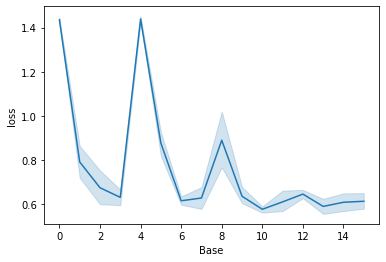

In [53]:
loss_plot('Base', TRIALS)

### **Training the Final Model**

In [57]:
# Run through data pipeline
data_pipeline = pipeline(**best_params['preprocessing'])
X_train_c = data_pipeline.fit_transform(X_train)
X_val_c = data_pipeline.transform(X_val)

# Run through model
best_params['model'].update(default_params)
final_ngb = NGBRegressor(**best_params['model']).fit(X_train_c, y_train, X_val=X_val_c, Y_val=y_val, early_stopping_rounds=5)

/Users/matt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/matt/anaconda3/lib/python3.7/site-packages/ngboost/distns/normal.py:68: RuntimeWarning: overflow encountered in square
  self.var = self.scale ** 2


[iter 0] loss=1.5178 val_loss=1.4697 scale=1.0000 norm=1.0617
[iter 1] loss=1.3167 val_loss=1.3673 scale=2.0000 norm=1.7612
[iter 2] loss=1.2346 val_loss=1.2705 scale=2.0000 norm=1.6369
[iter 3] loss=1.1755 val_loss=1.2353 scale=2.0000 norm=1.5377
[iter 4] loss=1.1525 val_loss=1.2018 scale=2.0000 norm=1.5271
[iter 5] loss=1.1108 val_loss=1.1744 scale=2.0000 norm=1.4672
[iter 6] loss=1.0814 val_loss=1.1465 scale=2.0000 norm=1.4122
[iter 7] loss=1.0668 val_loss=1.1229 scale=2.0000 norm=1.4233
[iter 8] loss=1.0405 val_loss=1.0988 scale=2.0000 norm=1.4006
[iter 9] loss=1.0174 val_loss=1.0771 scale=2.0000 norm=1.3729
[iter 10] loss=0.9913 val_loss=1.0521 scale=2.0000 norm=1.3470
[iter 11] loss=0.9762 val_loss=1.0311 scale=2.0000 norm=1.3538
[iter 12] loss=0.9487 val_loss=1.0121 scale=2.0000 norm=1.3064
[iter 13] loss=0.9184 val_loss=0.9920 scale=2.0000 norm=1.2819
[iter 14] loss=0.9084 val_loss=0.9729 scale=2.0000 norm=1.2839
[iter 15] loss=0.8816 val_loss=0.9565 scale=2.0000 norm=1.2597
[i

We can evaluate our model with various metrics on the test set:

In [58]:
# Run test data set through pipeline
X_test = data_pipeline.transform(X_test)

In [61]:
y_pred = final_ngb.predict(X_test)
y_dist = final_ngb.pred_dist(X_test)
mae = median_absolute_error(y_test, y_pred)
mea = mean_absolute_error(y_test, y_pred)
nll = -y_dist.logpdf(y_test).mean()
print(f'MAE: {mae:0.3f}, MAE: {mea:0.3f}, NLL: {nll:0.3f}')

MAE: 0.183, MAE: 0.330, NLL: 0.651


Let's save the model:

In [64]:
pickle.dump(final_ngb, open(NGB_PATH, 'wb'))